In [1]:
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go

np.random.seed(42)

# Basic Modeling

For this exercise we are going to use synthetic data to illustrate the basic ideas of model design.

In [2]:
n = 100      # Number of records 

noise = 0.5  # Noise in observations (we wouldn't know this in real life)
m = 1.5      # The true slope (we wouldn't know this in real life) 
b = 3.0      # The true intercept (we wouldn't know this in real life)

# Make the data --------------------------
X = np.random.rand(n) * 4. - 2.
# The Y values are created using the secret model 
#      (We wouldn't have this in real-life either)
Y = m * X + b + np.random.randn(n) * noise

# Visualize the data ---------------------
raw_data = go.Scatter(name = "Data", x = X, y = Y, mode = 'markers')
py.iplot([raw_data])

## The Simplest model

What is the simplest model for this data? We know how the data was created but let's imagine we did not.

Recall that we are trying to "model" the relationship between $x$ and $y$.  Let's focus on the class of **parametric** models that are functional relationships defined by a set of **parameters** $\theta$:

$$
f_\theta: x \rightarrow y
$$

### The constant function:

Here is a very simple model:

$$
f_\theta(x) = \theta
$$

Notice that this model is determined by a single number $\theta$.  How should we determine $\theta$?  Perhaps we can guess a good value for $\theta$?  I propose we use the mean value of $y$.  Why might this be a good guess?

In [3]:
# Define our simple constant model:
def f_const(theta, x):
    return theta 

theta_guess = np.mean(Y)
yhat = [f_const(theta_guess, x) for x in X]

# Visualize the data ---------------------
theta_guess_line = go.Scatter(name="First Guess", x = X, y = yhat, mode = 'lines',
    line = dict(color = 'red')
)
py.iplot([raw_data, theta_guess_line])

### Is this the best model?

Is this a good approximation of the data?  What does it mean to be a good approximation of the data?  

To answer these questions we need to define a **loss function** to measure how well the model approximates the data.  A very common loss function is the **squared loss** which measures the squared difference between what the model predicts $f_\theta(x)$ and the observed response $y$.  

$$
L(y, f_\theta(x)) = \left( y - f_\theta(x) \right)^2
$$

The **squared loss** is the foundation of the **least squares** method which is widely used in function approximation and modeling and can be applied to a wide range of models (not just linear models).

If we have many data points (and hopefully we do) then we define the loss over the entire dataset as:

$$
L_D(\theta) = \frac{1}{n} \sum_{i=1}^n L(y_i, f_\theta(x_i))
$$

Notice that in the above notation we have defined the loss $L_D(\theta)$ as a function of only the parameters $\theta$ and are assuming the model form $f$ and the data $D$ are fixed.  If we consider the squared loss we get:

$$
L_D(\theta) = \frac{1}{n} \sum_{i=1}^n \left( y_i -  f_\theta(x_i) \right)^2
$$


--- 

<br/><br/><br/>
We can plot the **loss function** for our simple model and our best guess

In [4]:
# Single point loss function
def sq_loss(y, pred):
    return (y - pred)**2

# Loss over the entire dataset for a given thena
def loss(f, theta):
    return np.mean([sq_loss(y, f(theta, x)) for (x,y) in zip(X,Y)])

# Generate a range of possible theta values (models)
theta_values = np.linspace(0, 5, 100)

# Compute the loss of each
loss_values = [loss(f_const, theta) for theta in theta_values]


### Plotting code ---------
loss_curve = go.Scatter(name="Loss Function", x = theta_values, y = loss_values, mode = 'lines')
best_guess = go.Scatter(name="Best Guess", x = theta_guess, y = loss(f_const, theta_guess), 
                        mode = 'markers',
                        marker=dict(color="red", size=20))
layout = go.Layout(
    xaxis=dict(
        title="Theta Value"
    ),
    yaxis=dict(
        title="Loss Value"
    )
)
fig = go.Figure(data = [loss_curve,best_guess], layout = layout)
py.iplot(fig)

**Observation:** *The loss function is a smooth quadratic curve.*

This is not an artifact of our data.  In general, when we combine the squared loss with a linear model (more on this later) we will get nice quadratic loss curves (potentially in many dimensions).


## Minimize the Loss with Calculus


We guessed that best $\theta$ value for the model $f_\theta(x) = \theta$ would be $\theta = \frac{1}{n} \sum_{i=1}^n y_n$ (the red circle in the above figure).  This was a good guess!!  

However, a more general procedure would be to use calculus to minimize the loss function. 

**Beginners Convex Optimization Recipe:**
1. Take derivative of the loss function 
1. Solve for paramter values by setting derivative equal to zero:

We are trying to compute the point where the derivative is zero:

<img src="convex_function.png" width="400px">

Working through the calculations for our very simple constant function:

\begin{align*}
\frac{\partial}{\partial \theta} L_D(\theta) 
& = \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial \theta} \left( y_i -  f_\theta(x_i) \right)^2 \\
& = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  f_\theta(x_i) \right) \frac{\partial}{\partial \theta} f_\theta(x_i) \\
& = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \theta \right)
\end{align*}

where the last line comes from the assumption that our model is $f_\theta(x) = \theta$ and therefore $\frac{\partial}{\partial \theta} f_\theta(x_i) = 1$.  Setting this equal to zero we get:


\begin{align*}
0 & = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \theta \right)  \\
0 & = \frac{2}{n} \sum_{i=1}^n y_i -  \theta \frac{2 n}{n} \\
\theta \frac{2 n}{n} & = \frac{2}{n} \sum_{i=1}^n y_i   \\
\theta  & = \frac{1}{n} \sum_{i=1}^n y_i   
\end{align*}

Therefore the loss minimizing assignment to $\theta$ is the average value of $y$.

**Could we improve our model?**

You may recall from introductory math classes the equation of a line:

$$
y = m \, x + b
$$

a line is one of the simplest models we might use to represent the relationship between an input $x$ and an output $y$.  We could write this as the model:

$$
f_{(m,b)}(x) = m \, x + b
$$

This is a **parametric model** parameterized by $m$ and $b$.  Adopting our earlier notation we define $\theta = (m, b)$ and rewrite our improved model:

$$
f_\theta(x) = \theta_0 x + \theta_1
$$

Now that we have a new model how should we select our parameters?  We would like to minimize our loss but what does it look like. 



In [5]:
# Our new model
def f_line(theta, x):
    return theta[0] * x + theta[1]

# To visualize the loss I need to generate many theta0, theta1 pairs. 
# This is done using meshgrid
(theta0,theta1) = np.meshgrid(np.linspace(0,3,20), np.linspace(1,5,20))
theta_values = np.vstack((theta0.flatten(), theta1.flatten())).T

# Evaluating the loss for all theta values
loss_values = [loss(f_line, theta) for theta in theta_values]

# Plotting code! ------------------------

# Here I make a 3d surface plot.  X, Y, and Z must all be _matrices_ 
# corresponding to the x, y, z values for each point on the x,y plane 
loss_surface = go.Surface(
    x = theta0,
    y = theta1,
    z = np.reshape(loss_values, theta1.shape)
)

# Axis labels
layout = go.Layout(
    scene=go.Scene(
        xaxis=go.XAxis(title='theta_0'),
        yaxis=go.YAxis(title='theta_1'),
        zaxis=go.ZAxis(title='loss'),
        aspectratio=dict(x=1.,y=1., z=1.)
    )
)
fig = go.Figure(data = [loss_surface], layout = layout)
py.iplot(fig)


Spin the above plot and guess what might be optimal values for $\theta$ (and admire D3 WebGL enabled visualizations).  

**Notice:** *The plot is quadratic like the earlier 1-dimensional loss function.*


## Minimizing the Loss Function

Let's now try to derive the minimizing values for our parameters:

\begin{align*}
\frac{\partial}{\partial \theta_0} L_D(\theta) 
& = \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial \theta_0} \left( y_i -  f_\theta(x_i) \right)^2 \\
& = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  f_\theta(x_i) \right) \frac{\partial}{\partial \theta_0} f_\theta(x_i) \\
& = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i - \left(\theta_0 x_i + \theta_1 \right) \right) x_i
\end{align*}

where the last line comes from the assumption that our model is $f_\theta(x) = \theta_0 x + \theta_1$ and therefore $\frac{\partial}{\partial \theta_0} f_\theta(x) = x$.  Taking the derivative with respect to $\theta_1$

\begin{align*}
\frac{\partial}{\partial \theta_1} L_D(\theta) 
& = \frac{1}{n} \sum_{i=1}^n \frac{\partial}{\partial \theta_1} \left( y_i -  f_\theta(x_i) \right)^2 \\
& = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  f_\theta(x_i) \right) \frac{\partial}{\partial \theta_1} f_\theta(x_i) \\
& = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \left(\theta_0 x_i + \theta_1\right) \right)
\end{align*}


Setting both derivatives equal to zero we get the following system of equations:

\begin{align*}
0 & = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \theta_0 x_i - \theta_1 \right) x_i \\
0 & = \frac{1}{n} \sum_{i=1}^n  2 \left( y_i -  \theta_0 x_i - \theta_1 \right)
\end{align*}





We can do some algebra to make things a bit clearer:


\begin{align*}
\sum_{i=1}^n  x_i y_i  & =   \theta_0  \sum_{i=1}^n  x_i x_i + \theta_1  \sum_{i=1}^n  x_i \\
\sum_{i=1}^n y_i  & =   \theta_0  \sum_{i=1}^n  x_i + \theta_1 n
\end{align*}

To simplify the math we can define constants (statistics computed from the data directly):

\begin{align*}
C_1 & = \sum_{i=1}^n  x_i y_i  \quad &  \quad C_2  &=  \sum_{i=1}^n  x_i x_i \\
C_3 & = \sum_{i=1}^n  x_i \quad & \quad C_4 & = \sum_{i=1}^n y_i 
\end{align*}

Substituting the constants it becomes clear that we have a classic system of linear equations:

\begin{align*}
C_1 & =   \theta_0  C_2 + \theta_1  C_3 \\
C_4 & =   \theta_0  C_3 + \theta_1 n
\end{align*}

Which we can solve analytically through some simple but tedious algebra.  However, because algebra is tedious and we are data scientists who use technology to tackle problems (and make our lives easier) let's make a symbolic algebra library do the tricky work for us:

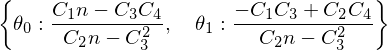

In [6]:
import sympy

# Define the variables (symbols) that we will use in our equation
theta0 = sympy.Symbol("theta0")
theta1 = sympy.Symbol("theta1")
c1 = sympy.Symbol("C1")
c2 = sympy.Symbol("C2")
c3 = sympy.Symbol("C3")
c4 = sympy.Symbol("C4")
n = sympy.Symbol("n")

# Solve the system of equations (eq = 0) for theta0 and theta1
theta_hats_symb = sympy.solve(
    [
        theta0 * c2 + theta1 * c3 - c1, 
        theta0 * c3 + theta1 * n - c4 
    ], 
    [theta0, theta1])


# Print the answer (so pretty)
sympy.init_printing()
theta_hats_symb

Okay, so the above equation was pretty easy.  However, as we move to more complex models we will quickly find that both computing the derivatives and even solving them will require sophisticated analytic and numeric machinery.  The combination of symbolic differentiation and numerical optimization have been at the heart of recent advances in AI.

We can now compute the actual numerical values for the algebraic expressions above:

In [7]:
# Compute the actual numerical values for all the constants
subs = {
    c1: np.sum(X * Y),
    c2: np.sum(X * X),
    c3: np.sum(X),
    c4: np.sum(Y),
    n: len(X)
}

# For each theta value substitute the numerical values for the constans 
# and evaluate the expression
theta_hat = np.array([float(theta_hats_symb[theta0].evalf(subs=subs)), 
         float(theta_hats_symb[theta1].evalf(subs=subs))])
print(theta_hat)

[ 1.44252835  2.99260477]


We have just computed the "optimal" parameters for our original model. Returning to our earlier plot lets place the solution on the loss suface:

In [8]:
theta_hat_point = go.Scatter3d(
    x = theta_hat[0],
    y = theta_hat[1],
    z = loss(f_line, theta_hat),
    mode = 'markers', 
    marker = dict(color='red')
)

loss_surface.opacity = 0.9
fig = go.Figure(data = [loss_surface, theta_hat_point], layout = layout)
py.iplot(fig)

We can also plot the line defined by these parameters:

In [9]:
# Define my model:
yhat = [f_line(theta_hat, x) for x in X]

# Visualize the data ---------------------
theta_line = go.Scatter(name="Linear Model", x = X, y = yhat, mode = 'lines',
    line = dict(color = 'red')
)
theta_guess_line.line.color = "pink"
py.iplot([raw_data, theta_guess_line, theta_line])

Is this a better fit?

<br/> <br/> <br/>

---

# Quick Review


1. We introduced the idea **parametric functions** as a modeling primitive
1. We introduced the idea of the **loss function** and in particular the **squared** loss to determine how well our model approximates our data.
1. We then used calculus (and in particular convex optimization) to determine the model parameters that **minimize the loss function**

We will now generalize these ideas to the **parametric** function of a line.  

<br/><br/><br/><br/>


---

# Linear Model Family

The **linear model** is a generalization of our earlier two dimensional $y = m x + b$ model:

$$
f_\theta(x) = \sum_{j=1}^p \theta_j x_j
$$

**Note:**
1. This is the model for a **single data point** $x$
1. The data point is **$p$-dimensional**
1. The subscript $j$ is indexing each of the $p$ dimensions

To simplify the presentation we will use the following vector notation:

$$
f_\theta(x) =  x^T \theta
$$

You can see this in the following figure:

<img src="vector_dot.png" width="400px">

As we will see, shortly, this is a very expressive parametric model.  In previous lectures we derived the **Least Squares** parameter values for this model.  Let's derive them again.

## Least Squares Linear Regression

Before we proceed we need to define some new notation to describe the entire dataset.  We introduce the design (covariate) matrix $X$ and the response matrix (vector) $Y$ which encode the data:

<img src="design_matrix.png" width="400px">

**Notes:**
1. The **rows** of $X$ correspond to records (e.g., users in our database)
1. The **columns** of $X$ correspond to **features** (e.g., the age, income, height).
1. **CS and Stats Terminology Issue:** In statistics we use $p$ to denote the number of columns in $X$ which corresponds to the number of *parameters* in the corresponding linear model.  In computer science we use $d$ instead of $p$ to refer to the number of columns.  The $d$ is in reference to the *dimensionality* of each record.  You can see the differences in focus on the model and the data. If you get confused just flip the paper (or your computer) upside down and it will make more sense.



### Loss Minimization:

We can write the loss using the matrix notation:

\begin{align}
L_D(\theta) 
& = 
\frac{1}{n}\sum_{i=1}^n \left(Y_i -  f_\theta(X_i)\right)^2 \\
& = 
\frac{1}{n}\sum_{i=1}^n \left(Y_i -  X_i \theta \right)^2 \\
& = 
\frac{1}{n}\left(Y -  X \theta \right)^T \left(Y -  X \theta \right) 
\end{align}

Note that the last line $X_i \theta$ is the dot product of the 

<img src="matrix_dot.png" width="400px">

We can further simply the last expression by expanding the product:

\begin{align}
L_D(\theta) 
& = 
\frac{1}{n}\left(Y -  X \theta \right)^T \left(Y -  X \theta \right) \\
& = 
\frac{1}{n}\left(Y^T \left(Y -  X \theta \right) -  \left(X \theta\right)^T \left(Y -  X \theta \right) \right) \\
& = 
\frac{1}{n}\left( 
   Y^T Y -  Y^T X \theta  - \left(X \theta \right)^T Y + \left(X \theta \right)^T  X \theta 
\right) \\
& =
\frac{1}{n} \left( 
 Y^T Y -  2 Y^T X \theta + \theta^T  X^T  X \theta 
\right)
\end{align}

**Note:** Because $\left(X \theta \right)^T Y$ is a scalar it is equal to its transpose $Y^T X \theta$ 
and therefore $- Y^T X \theta  - \left(X \theta \right)^T Y  = -2 Y^T X \theta$.



## Computing the Loss Minimizing $\theta$ 
Recall our goal is to compute:

\begin{align}
\hat{\theta} = \arg \min_\theta L(\theta)
\end{align}


Which we can compute by taking the **gradient** of the loss and setting it equal to zero.


\begin{align}
\nabla_\theta L(\theta) 
& =
\frac{1}{n} \left( 
 \nabla_\theta Y^T Y -  \nabla_\theta 2 Y^T X \theta + \nabla_\theta \theta^T  X^T  X \theta 
\right) \\
& =
\frac{1}{n} \left( 
 0 -  2 X^T Y  +  2 X^T  X \theta 
\right) 
\end{align}

The above gradient derivation uses the following identities:
1. $\nabla_\theta \left( A \theta  \right) = A^T$
1. $\nabla_\theta \left( \theta^T A \theta \right) = A\theta + A^T \theta$ and $A = X^T X$ is symmetric

Setting the gradient equal to zero we get the famous **Normal Equations**:

$$
X^T  X \theta =  X^T Y
$$



$$
 \theta = \left(X^T  X\right)^{-1} X^T Y
$$




# The Normal Equation

The normal equations define the least squares optimal parameter value  $\hat{\theta}$ for the linear regression model:

$$
 \hat{\theta} = \left(X^T  X\right)^{-1} X^T Y
$$

and have the pictorial interpretation of the matrices:

<img src="normal_equations.png" width="400px">

It is worth noting that for common settings where $n >> p$ (i.e., there are many records and only a few dimensions) the matrix $X^T X$ and $X^T Y$ are small relative to the data.  


# Working with the Normal Equation

Now that we have the normal equation let's apply it to compute the optimal $\theta$ for our toy dataset. 

In [10]:
# Because X is 1 dimensional ... we need to use scalar inversion
theta_hat = (X.T @ X)**-1 * (X.T @ Y)

print(theta_hat)

1.1904575072


Plotting our least-squares regression line:

In [11]:
yhat = X * theta_hat

# Visualize the data ---------------------
normal_equation_line = go.Scatter(name="Normal Equation", x = X, y = yhat, mode = 'lines',
    line = dict(color = 'red')
)
py.iplot([raw_data, normal_equation_line])

## Stuck on the origin!

Remember our general linear model: 

$$
f_\theta(x) = \sum_{j=1}^p \theta_j x_j
$$

doesn't have the **"bias"** term $b$ we had in our line equation:

$$
y = m x + b
$$  

However we can begin our journey into **feature engineering** by adding an extra **constant** (typically 1) to each record:

<img src="adding_bias_term.png" width="400px">

This extra **feature** will allow our general linear model to represent a **bias** term.

For reasons we will see later, I am going to call this a feature transformation $\phi(X)$.  For notational convenience I will occasionally write $\Phi = \phi(X)$.



In [12]:
def phi(x):
    return np.array([x, 1.])

Phi = np.array([phi(x) for x in X]) # more efficient: Phi = np.vstack((X, np.ones(n))).T
Phi[:5,]

array([[-0.50183952,  1.        ],
       [ 1.80285723,  1.        ],
       [ 0.92797577,  1.        ],
       [ 0.39463394,  1.        ],
       [-1.37592544,  1.        ]])

Using the normal equations again:

In [13]:
theta_hat = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ Y
print(theta_hat)

[ 1.44252835  2.99260477]


A more numerically stable and efficient way to compute $A^{-1} b$ is to use `np.linalg.solve` which computes the solution to $A \theta = b$ rather than first computing inverse of $A$ and then multiplying by $b$.

In [14]:
theta_hat = np.linalg.solve(Phi.T @ Phi, Phi.T @ Y)
print(theta_hat)

[ 1.44252835  2.99260477]


Plotting the fit once more.  Notice this time  `yhat` (i.e., $\hat{y}$) is computed using `Phi` (i.e., $\Phi$) instead of `X`.

In [15]:
yhat = Phi @ theta_hat # Phi instead of X

# Visualize the data ---------------------
normal_equation_line2 = go.Scatter(name="Normal Equation", x = X, y = yhat, mode = 'lines',
    line = dict(color = 'red')
)
py.iplot([raw_data, normal_equation_line2])

**Success! **

---

## Moving to a Higher Dimensional Plane

Something interesting just happened.  The linear model went from **one** dimension to **two** dimensions.  We added a **feature** (i.e., a dimension) to each record. In a sense we took points on the `(x,y)` plane above and moved them into 3-dimensions: `(x, 1, y)`.

We can actually plot the data in 3 dimensions and see the corresponding plane of best fit:

In [16]:
raw3d = go.Scatter3d(
    name = "Raw Data",
    x = Phi[:,0],
    y = Y,
    z = Phi[:,1],
    mode = 'markers',
    marker = dict(size=3)
)

(u,v) = np.meshgrid(np.linspace(-3,3,20), np.linspace(-3,3,20))
coords = np.vstack((u.flatten(),v.flatten())).T
ycoords = coords @ theta_hat

fit_plane = go.Surface(
    name = "Fitting Hyperplane",
    x = np.reshape(coords[:,0], (20,20)),
    y = np.reshape(ycoords, (20,20)),
    z = np.reshape(coords[:,1], (20,20)),
    opacity = 0.8,
    cauto = False,
    showscale = False,
    colorscale = [[0, 'rgb(255,0,0)'], [1, 'rgb(255,0,0)']]
)

origin = go.Scatter3d(
    name = "Origin (0,0,0)",
    x = [0],
    y = [0],
    z = [0],
    mode = 'markers', 
    marker = dict(color='black')
)

data_plane = go.Mesh3d(
    name = "2D Plot",
    x = [-3,3,3,-3],
    y = [-10,-10,10,10],
    z = [1,1,1,1],
    i = [0,1],
    j = [1,2],
    k = [3,3],
    opacity = 0.5,
    color = 'gray'
)


loss_surface.opacity = 0.9
fig = go.Figure(data = [raw3d, fit_plane, origin, data_plane])
py.iplot(fig)

Spin the above plot around, because it is pretty and also you will learn something. Try spinning the plot so you look down on the **gray** plane and you should see the original data as though it were plotted in two dimensions.

**Notice:** 
1. The **red** plane is the plane corresponding to the model which passes through the points.
1. The **red** plane still passes through the origin (the big black circle).
1. The **gray** plane is the plane corresponding to the 2D plot in which the data originally lived.  
1. The intersection of the **red** and **gray** planes is the line of best fit with the bias term added!

You will notice that our data lives on the plane 3 dimensions and that the plane (in red) passes through the origin. 

This is a key theme with linear regression. That is by transforming the input we can often make complex data live on a plane that passes through the origin.

## A Note on the Bias Term

The **bias** term can be crucial for modeling data.  Most software packages will have an option to add a bias term to the model.  This is often implemented by transforming the input data though one has to be careful about adding how the bias term is treated in certain model tuning procedures (e.g., regularization which we will cover shortly).

In the next notebook we will explore **Feature Engineering** in much greater detail.